In [136]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

# -------------------------------------
# 2. CONFIGURACIÓN
# -------------------------------------

In [137]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10807968147813930540
xla_global_id: -1
]
2.15.0


In [138]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [139]:
mixed_precision.set_global_policy('float32')

# Parámetros
img_size = (224, 224)
batch_size = 32
epochs = 100
seed = 123
train_dir = '../dataset/multi-6/train'
model_path = 'efficientnetb0_derma_v2.keras'

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


# -------------------------------------
# 3. DATA AUGMENTATION Y GENERADORES
# -------------------------------------

In [140]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
# Obtener número de clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)


Found 30900 files belonging to 6 classes.
Using 24720 files for training.
Found 30900 files belonging to 6 classes.
Using 6180 files for validation.
Clases: ['Acne', 'Benign', 'Eczema', 'Infectious', 'Malign', 'Pigmentation']
Imagen shape: (32, 224, 224, 3)
Etiqueta: [0 1 3 1 1 3 0 4 2 2 1 3 1 1 5 1 3 4 1 1 1 3 1 1 1 1 2 1 2 3 1 0]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [0 1 5 1 1 1 4 3 1 0 3 1 4 1 3 4 4 1 2 1 5 4 4 4 3 1 2 0 4 1 1 4]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [1 0 0 4 1 3 1 4 1 3 3 4 5 4 3 4 2 4 1 4 3 4 4 1 4 4 1 3 3 3 1 1]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [1 3 1 1 1 1 1 1 4 0 3 4 1 2 3 1 1 5 2 1 4 2 3 3 4 4 2 2 1 1 1 2]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [2 4 1 1 2 3 3 3 4 3 1 0 1 1 3 5 3 5 2 4 2 1 3 1 1 0 0 4 3 4 1 0]


In [141]:
# ---------------------------------------
# PENALIZACIÓN ADICIONAL POR PELIGROSIDAD
# ---------------------------------------
# Define tus grupos
high_danger = {4}              # Malign
moderate_danger = {2, 3}       # Eczema, Infectious
low_danger = set(range(num_classes)) - high_danger - moderate_danger

# Define el multiplicador por peligrosidad
danger_multipliers = {}
for c in range(num_classes):
    if c in high_danger:
        danger_multipliers[c] = 3.0
    elif c in moderate_danger:
        danger_multipliers[c] = 2.0
    else:
        danger_multipliers[c] = 1.0

# ---------------------------------------
# AJUSTE FINAL DE class_weight
# ---------------------------------------
adjusted_class_weight = {}
for cls, base_weight in class_weight.items():
    adjusted_class_weight[cls] = base_weight * danger_multipliers[cls]

print("Pesos ajustados por clase:", adjusted_class_weight)

Pesos por clase: {0: 2.3965410268341865, 1: 0.4733609068627451, 2: 1.2653972153972155, 3: 0.8583611111111111, 4: 0.7592756400805937, 5: 5.054138043833824}


In [142]:
# ----------------------------
# PENALIZACIÓN EN CLASES CON MAYOR RIESGO
# ----------------------------

high_danger = {4} #Malign

moderate_danger = {2, 3} #Eczema, Infectious

low_danger = set(range(num_classes)) - high_danger - moderate_danger  #Benign, pigmentation, acne

cost_matrix = tf.ones([num_classes, num_classes])           # baseline cost = 1

cost_matrix = tf.where(tf.eye(num_classes) == 1, 0., cost_matrix)     # zero on the diagonal

# Penalizes False Negatives for the high and moderate danger

for high in high_danger:
    for low in low_danger:
        cost_matrix = tf.tensor_scatter_nd_update(cost_matrix,
                                        indices=[[high, low]],
                                        updates=[10.0]) 
        
    for mid in moderate_danger:
        cost_matrix = tf.tensor_scatter_nd_update(cost_matrix,
                                        indices=[[high, mid]],
                                        updates=[5.0]) 
        
for mid in moderate_danger:
    for low in low_danger:
        cost_matrix = tf.tensor_scatter_nd_update(cost_matrix,
                                        indices=[[mid, low]],
                                        updates=[5.0])
        
print(cost_matrix)


tf.Tensor(
[[ 0.  1.  1.  1.  1.  1.]
 [ 1.  0.  1.  1.  1.  1.]
 [ 5.  5.  0.  1.  1.  5.]
 [ 5.  5.  1.  0.  1.  5.]
 [10. 10.  5.  5.  0. 10.]
 [ 1.  1.  1.  1.  1.  0.]], shape=(6, 6), dtype=float32)


In [143]:
def cost_matrix_sparse_categorical_crossentropy_loss(
        y_true, y_pred, alpha=1.0):

    num_classes = cost_matrix.shape[0]

    # 1.  Sparse → one‑hot           (B, C)
    y_true = tf.one_hot(tf.cast(tf.reshape(y_true, [-1]), tf.int32),
                        depth=num_classes)

    # 2.  Expected per‑class cost
    row_cost = tf.matmul(y_true, cost_matrix)      # or use the expand‑squeeze variant

    # 3.  Expected misclassification cost for each example
    exp_cost = tf.reduce_sum(row_cost * y_pred, axis=-1)

    # 4.  Standard cross‑entropy
    ce = tf.keras.losses.categorical_crossentropy(
            y_true, tf.nn.softmax(y_pred))

    return ce + alpha * exp_cost
    

In [144]:
"""y_true = tf.convert_to_tensor([[0.,0.,0.,0.,1.,0.]], dtype=tf.float32)
print(y_true.ndim)
y_pred = tf.convert_to_tensor([[0.2,0.2,0.,0.,0.47,0.13]], dtype=tf.float32)
print(y_pred.ndim)
loss = cost_matrix_sparse_categorical_crossentropy_loss(y_true, y_pred, cost_matrix)
print(loss)"""


'y_true = tf.convert_to_tensor([[0.,0.,0.,0.,1.,0.]], dtype=tf.float32)\nprint(y_true.ndim)\ny_pred = tf.convert_to_tensor([[0.2,0.2,0.,0.,0.47,0.13]], dtype=tf.float32)\nprint(y_pred.ndim)\nloss = cost_matrix_sparse_categorical_crossentropy_loss(y_true, y_pred, cost_matrix)\nprint(loss)'

In [145]:
# Optimización de rendimiento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Configuración de caché y prefetch
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [146]:
# Modelo base (preentrenado)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # congelamos capas base

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# Modelo completo (sin preprocessing dentro)
model = models.Sequential([
    base_model,
    data_augmentation,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

# Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight 
)

Epoch 1/100


133/773 [====>.........................] - ETA: 5:00 - loss: 2.3410 - accuracy: 0.3828

Found 30901 files belonging to 6 classes.
966/966 ━━━━━━━━━━━━━━━━━━━━ 2432s 3s/step
🧾 Clasification Report:

              precision    recall  f1-score   support

        Acne       0.92      0.94      0.93      2148
      Benign       0.94      0.90      0.92     10880
      Eczema       0.86      0.94      0.90      4070
  Infectious       0.87      0.92      0.89      6000
      Malign       0.91      0.87      0.89      6783
Pigmentation       0.91      0.91      0.91      1020

    accuracy                           0.90     30901
   macro avg       0.90      0.91      0.91     30901
weighted avg       0.91      0.90      0.90     30901



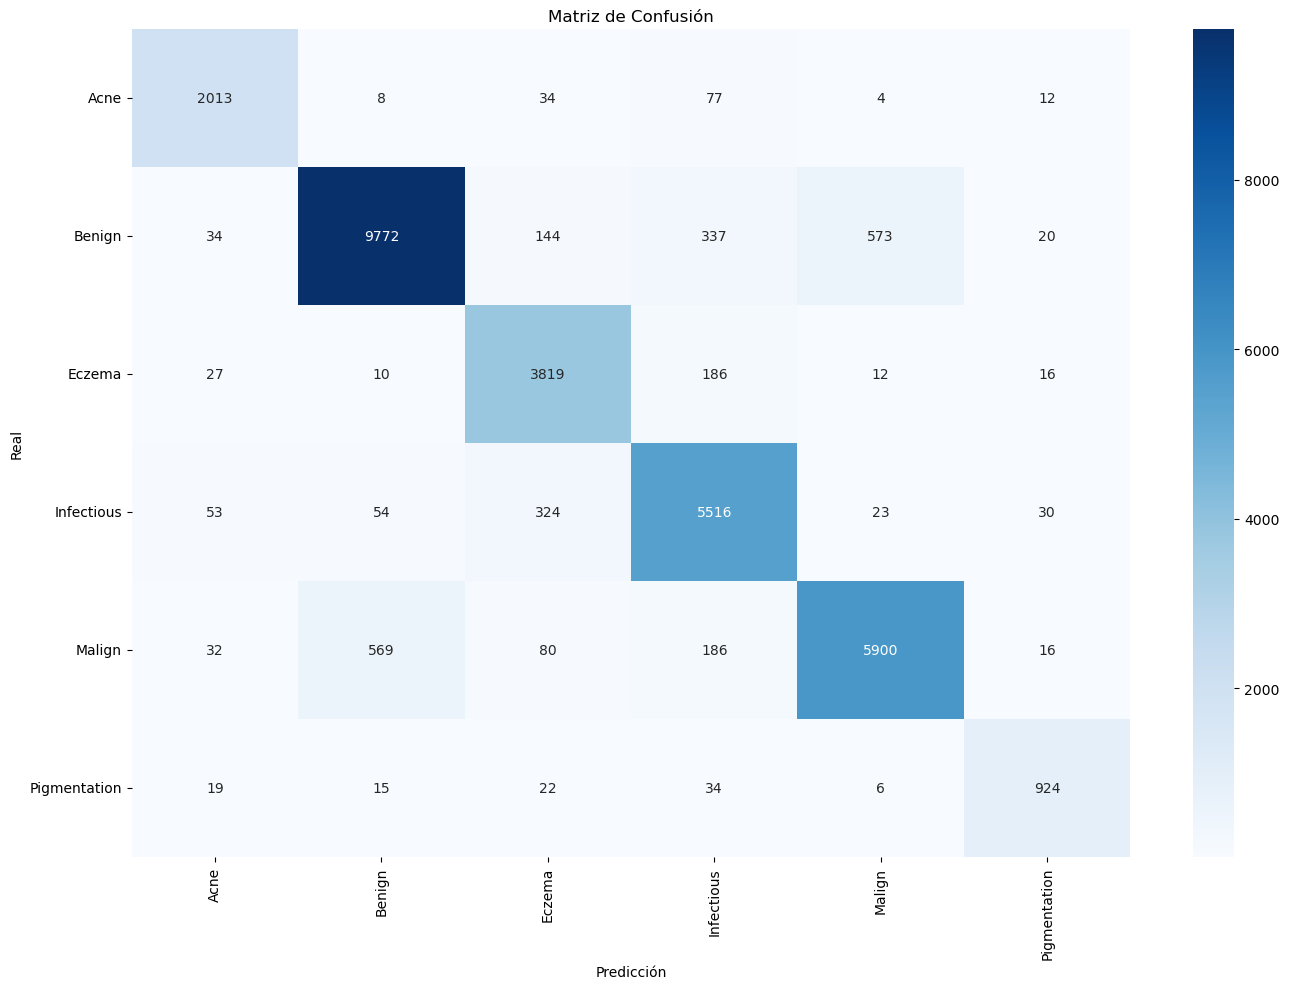

In [6]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Rutas
test_dir = '../../dataset/multi-6/test'

# Cargar modelo entrenado
model = tf.keras.models.load_model(model_path)

# Cargar dataset de test
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False  # MUY IMPORTANTE para alinear predicciones con etiquetas
)

# Obtener nombres de clase
class_names = test_ds.class_names
num_classes = len(class_names)

# Prefetch para acelerar
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Obtener predicciones
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales
y_true = np.concatenate([y.numpy() for x, y in test_ds])

# Reporte de clasificación
print("🧾 Clasification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
